# Project - Bank Churn Prediction

In [176]:
#!pip3.8 install tensorflow==2.4

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

warnings.filterwarnings('ignore')

%matplotlib inline

In [178]:
print(tf.__version__)

2.4.1


In [179]:
df = pd.read_csv('bank.csv')
df.shape

(10000, 14)

In [180]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [181]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, we will not require the first 2 attributes as the are specific to a customer. It is borderline with the surname as this would result to profiling so we exclude this as well.

In [182]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [183]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [184]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## Exploratory Data Analysis

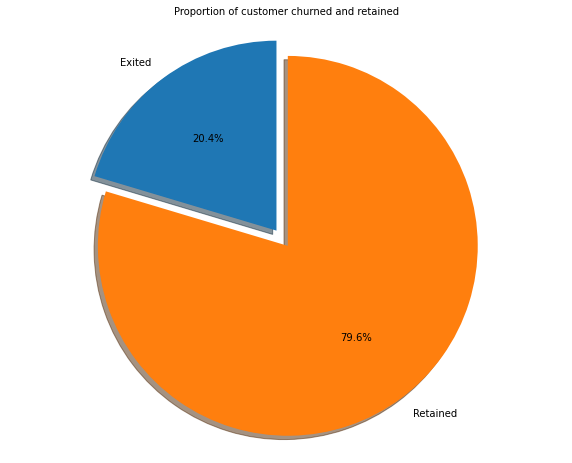

In [185]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 10)
plt.show()

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

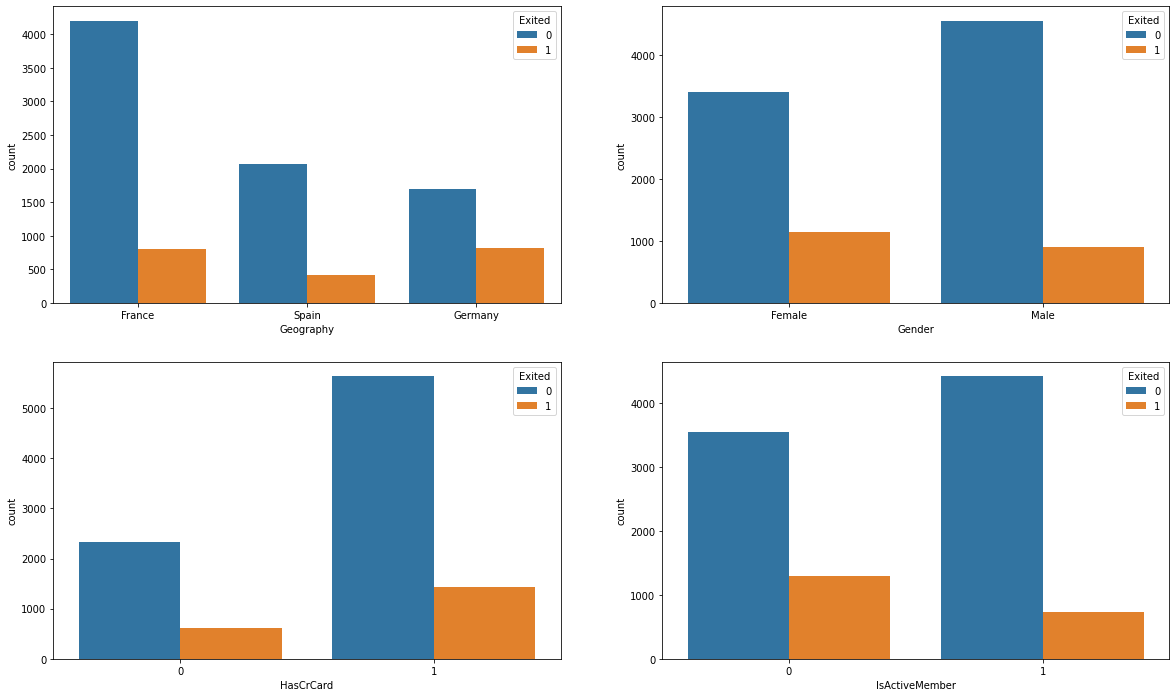

In [186]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

Notes from Pie chart and Histograms: 

1. The proportion of female customers churning is also greater than that of male customers
2. Majority of the customers that churned are those with credit cards
3. Inactive members have a greater churn
4. Churn rate is about 20% 

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

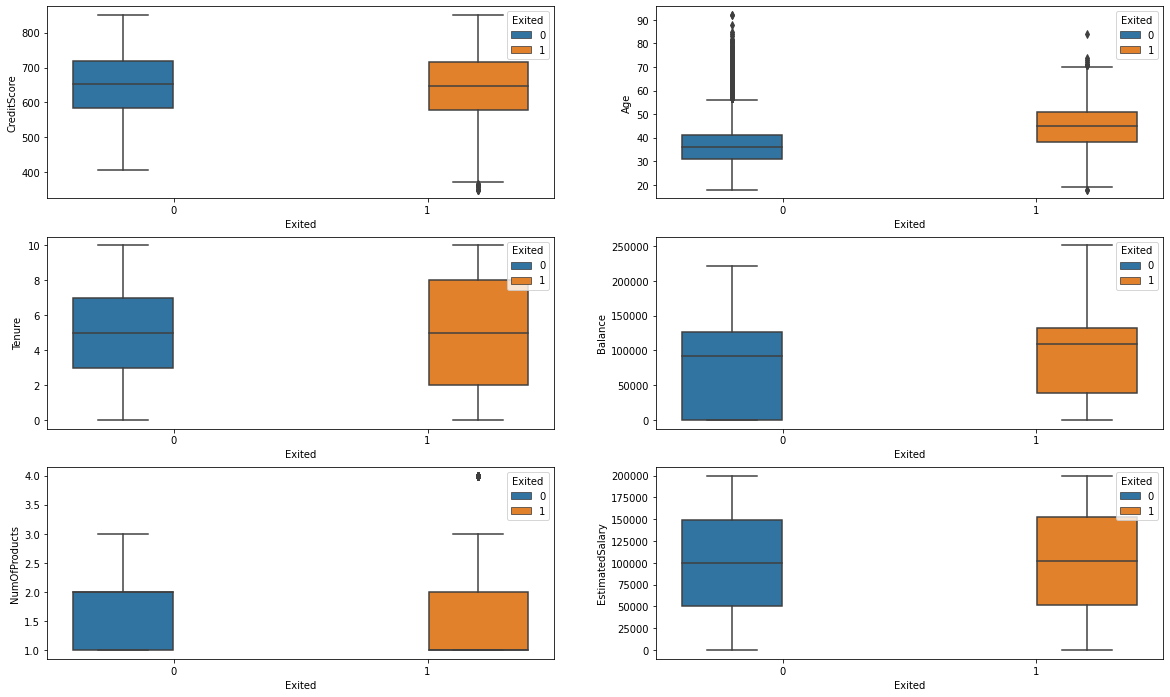

In [187]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

Notes from Box plots above: 
1. There is no significant difference in the credit score distribution between retained and churned customers.
2. The older customers are churning at more than the younger ones
3. Neither the product nor the salary has a significant effect on the likelihood to churn.
4. The Bank needs to review the target market

## Feature engineering

(-1.0, 5.0)

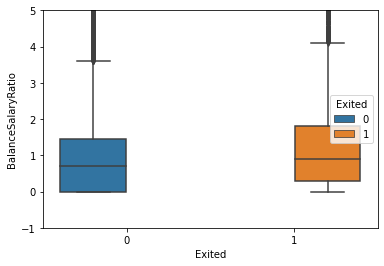

In [188]:
df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 5)

As seen above, the ratio of the bank balance and the estimated salary indicates that customers with a higher balance salary ratio churn more which would be worrying to the bank as this impacts their source of loan capital

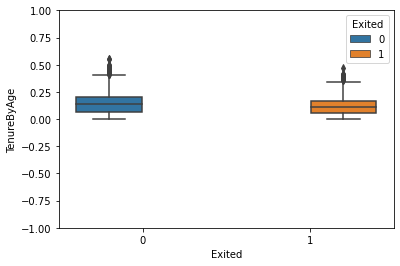

In [189]:
df['TenureByAge'] = df.Tenure/(df.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 1)
plt.show()

Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age

In [190]:
df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)

In [191]:
df.loc[df.HasCrCard == 0, 'HasCrCard'] = -1
df.loc[df.IsActiveMember == 0, 'IsActiveMember'] = -1
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095
1,608,Spain,Female,41,1,83807.86,1,-1,1,112542.58,0,0.744677,0.024390,14.829268
2,502,France,Female,42,8,159660.80,3,1,-1,113931.57,1,1.401375,0.190476,11.952381
3,699,France,Female,39,1,0.00,2,-1,-1,93826.63,0,0.000000,0.025641,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442


In [192]:
geo_label = LabelEncoder()
df['Geography'] = geo_label.fit_transform(df['Geography'])

In [193]:
gender_label = LabelEncoder()
df['Gender'] = geo_label.fit_transform(df['Gender'])

In [194]:
df = pd.get_dummies(df, drop_first=True, columns=['Geography'])
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Geography_1,Geography_2
0,619,0,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095,0,0
1,608,0,41,1,83807.86,1,-1,1,112542.58,0,0.744677,0.024390,14.829268,0,1
2,502,0,42,8,159660.80,3,1,-1,113931.57,1,1.401375,0.190476,11.952381,0,0
3,699,0,39,1,0.00,2,-1,-1,93826.63,0,0.000000,0.025641,17.923077,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442,0,1


## Splitting the data

In [195]:
X = df.drop(labels=['Exited'], axis = 1)
y = df['Exited']

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [197]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [198]:
X.shape

(10000, 14)

## Model Building

In [199]:
classifier = tf.keras.models.Sequential()
classifier.add(tf.keras.layers.Dense(X.shape[1], activation='relu', input_dim = X.shape[1]))
classifier.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [200]:
classifier.fit(X_train, y_train.to_numpy(), batch_size = 10, epochs = 100  )

Epoch 1/100
800/800 [==============================] - 1s 911us/step - loss: 0.5575 - accuracy: 0.7185
Epoch 2/100
800/800 [==============================] - 1s 968us/step - loss: 0.4125 - accuracy: 0.8235
Epoch 3/100
800/800 [==============================] - 1s 1ms/step - loss: 0.4015 - accuracy: 0.8321
Epoch 4/100
800/800 [==============================] - 1s 963us/step - loss: 0.3814 - accuracy: 0.8446
Epoch 5/100
800/800 [==============================] - 1s 920us/step - loss: 0.3745 - accuracy: 0.8476
Epoch 6/100
800/800 [==============================] - 1s 786us/step - loss: 0.3672 - accuracy: 0.8504
Epoch 7/100
800/800 [==============================] - 1s 827us/step - loss: 0.3439 - accuracy: 0.8560
Epoch 8/100
800/800 [==============================] - 1s 807us/step - loss: 0.3597 - accuracy: 0.8503
Epoch 9/100
800/800 [==============================] - 1s 789us/step - loss: 0.3391 - accuracy: 0.8599
Epoch 10/100
800/800 [==============================] - 1s 816us/step - los

800/800 [==============================] - 1s 871us/step - loss: 0.3237 - accuracy: 0.8628
Epoch 81/100
800/800 [==============================] - 1s 1ms/step - loss: 0.3212 - accuracy: 0.8672
Epoch 82/100
800/800 [==============================] - 1s 839us/step - loss: 0.3303 - accuracy: 0.8601
Epoch 83/100
800/800 [==============================] - 1s 908us/step - loss: 0.3287 - accuracy: 0.8641
Epoch 84/100
800/800 [==============================] - 1s 992us/step - loss: 0.3133 - accuracy: 0.8712
Epoch 85/100
800/800 [==============================] - 1s 972us/step - loss: 0.3226 - accuracy: 0.8669
Epoch 86/100
800/800 [==============================] - 1s 925us/step - loss: 0.3060 - accuracy: 0.8742
Epoch 87/100
800/800 [==============================] - 1s 935us/step - loss: 0.3252 - accuracy: 0.8680
Epoch 88/100
800/800 [==============================] - 1s 906us/step - loss: 0.3213 - accuracy: 0.8639
Epoch 89/100
800/800 [==============================] - 1s 919us/step - loss: 0

In [156]:
classifier.evaluate(X_test, y_test.to_numpy())

63/63 [==============================] - 0s 851us/step - loss: 0.7357 - accuracy: 0.5460


[0.7515200972557068, 0.5254999995231628]

In [157]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [158]:
print(accuracy_score(y_test, y_pred))

0.5255


<AxesSubplot:>

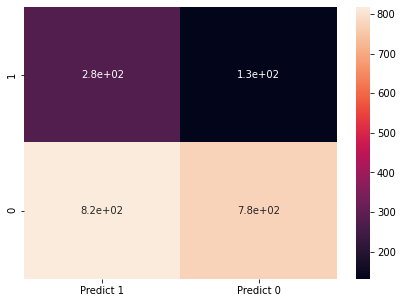

In [159]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

## Model tuning

In [160]:
def build_classifier(optimizer):
    classifier = tf.keras.models.Sequential()
    classifier.add(tf.keras.layers.Dense(X.shape[1], kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
    classifier.add(tf.keras.layers.Dense(6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
        

In [161]:
classifier = KerasClassifier(build_fn = build_classifier)

In [162]:
parameters = {'batch_size': [25, 32],'epochs': [100, 500], 'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy',cv = 10)
grid_search = grid_search.fit(X_train, y_train)

In [163]:
print(grid_search.best_params_)
print(grid_search.best_score_)

Based upon the Grid Search results, creating the improved model.

## Improved model

In [165]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(X.shape[1], kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
model.add(tf.keras.layers.Dense(6, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train.to_numpy(), batch_size = 32, epochs = 500, verbose = 1)

Epoch 1/500
250/250 [==============================] - 1s 943us/step - loss: 0.6382 - accuracy: 0.7964
Epoch 2/500
250/250 [==============================] - 0s 934us/step - loss: 0.4325 - accuracy: 0.7980
Epoch 3/500
250/250 [==============================] - 0s 935us/step - loss: 0.4079 - accuracy: 0.8268
Epoch 4/500
250/250 [==============================] - 0s 989us/step - loss: 0.3876 - accuracy: 0.8384
Epoch 5/500
250/250 [==============================] - 0s 863us/step - loss: 0.3895 - accuracy: 0.8382
Epoch 6/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3952 - accuracy: 0.8313
Epoch 7/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3779 - accuracy: 0.8431
Epoch 8/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3744 - accuracy: 0.8425
Epoch 9/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3730 - accuracy: 0.8463
Epoch 10/500
250/250 [==============================] - 0s 860us/step - loss: 0.3

250/250 [==============================] - 0s 1ms/step - loss: 0.3215 - accuracy: 0.8692
Epoch 159/500
250/250 [==============================] - 0s 979us/step - loss: 0.3083 - accuracy: 0.8733
Epoch 160/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3243 - accuracy: 0.8626
Epoch 161/500
250/250 [==============================] - 0s 928us/step - loss: 0.3141 - accuracy: 0.8676
Epoch 162/500
250/250 [==============================] - 0s 834us/step - loss: 0.3231 - accuracy: 0.8643
Epoch 163/500
250/250 [==============================] - 0s 919us/step - loss: 0.3147 - accuracy: 0.8752
Epoch 164/500
250/250 [==============================] - 0s 949us/step - loss: 0.3265 - accuracy: 0.8641
Epoch 165/500
250/250 [==============================] - 0s 954us/step - loss: 0.3235 - accuracy: 0.8634
Epoch 166/500
250/250 [==============================] - 0s 908us/step - loss: 0.3147 - accuracy: 0.8659
Epoch 167/500
250/250 [==============================] - 0s 960us/step - 

250/250 [==============================] - 0s 1ms/step - loss: 0.3017 - accuracy: 0.8705
Epoch 316/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3092 - accuracy: 0.8697
Epoch 317/500
250/250 [==============================] - 0s 942us/step - loss: 0.3065 - accuracy: 0.8703
Epoch 318/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3119 - accuracy: 0.8687
Epoch 319/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8715
Epoch 320/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3150 - accuracy: 0.8662
Epoch 321/500
250/250 [==============================] - 0s 1ms/step - loss: 0.3152 - accuracy: 0.8669
Epoch 322/500
250/250 [==============================] - 0s 952us/step - loss: 0.3111 - accuracy: 0.8704
Epoch 323/500
250/250 [==============================] - 0s 891us/step - loss: 0.3070 - accuracy: 0.8745
Epoch 324/500
250/250 [==============================] - 0s 1ms/step - loss: 0.31

In [201]:
y_pred = model.predict_classes(X_test)
y_pred = (y_pred > 0.5)

In [202]:
print(accuracy_score(y_test, y_pred))

0.855


<AxesSubplot:>

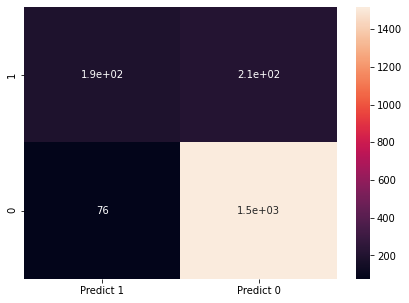

In [203]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

After improvement the accuracy of the model has been increased to 85%.